# 📌 Objective of the Notebook
### This notebook is designed to:
### - Build a classification model to predict `Credit_Score` using customer attributes.
### - Use preprocessing, feature engineering, and SMOTE for handling class imbalance.
### - Train a `CatBoostClassifier` with hyperparameter tuning using `GridSearchCV`.
### - Evaluate the model performance with accuracy and classification report.

# 📦 Importing Required Libraries
### These libraries are essential for Data Manipulation, Model Training and Evaluation.

In [31]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# 📂 Load the Dataset

In [32]:
train_path = "/kaggle/input/credit-score-classification/train.csv"
df = pd.read_csv(train_path, low_memory=False)

# Check if target column exists
if 'Credit_Score' not in df.columns:
    raise ValueError("Target column 'Credit_Score' is missing in the training set.")

df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


# 📈 Data Distribution Visualization

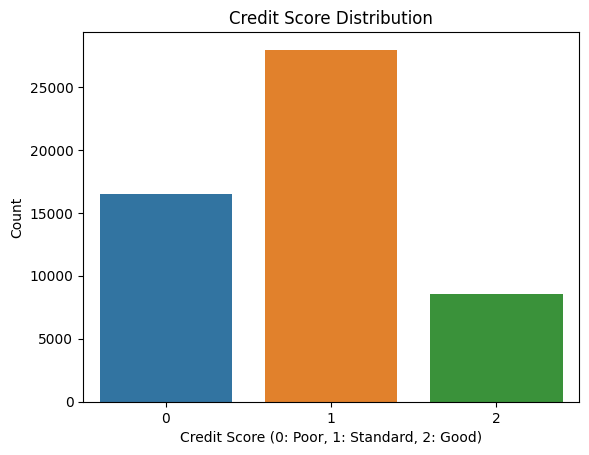

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the raw data manually if analyzer.df is not accessible
df_raw = pd.read_csv('/kaggle/input/credit-score-classification/train.csv')

# Drop rows with missing values for visualization
df_cleaned = df_raw.dropna()

# Map target labels to numeric for consistency with training
label_map = {'Poor': 0, 'Standard': 1, 'Good': 2}
df_cleaned['Credit_Score'] = df_cleaned['Credit_Score'].map(label_map)

# Plot
sns.countplot(data=df_cleaned, x='Credit_Score')
plt.title('Credit Score Distribution')
plt.xlabel('Credit Score (0: Poor, 1: Standard, 2: Good)')
plt.ylabel('Count')
plt.show()

# 📊 Feature Correlation Heatmap

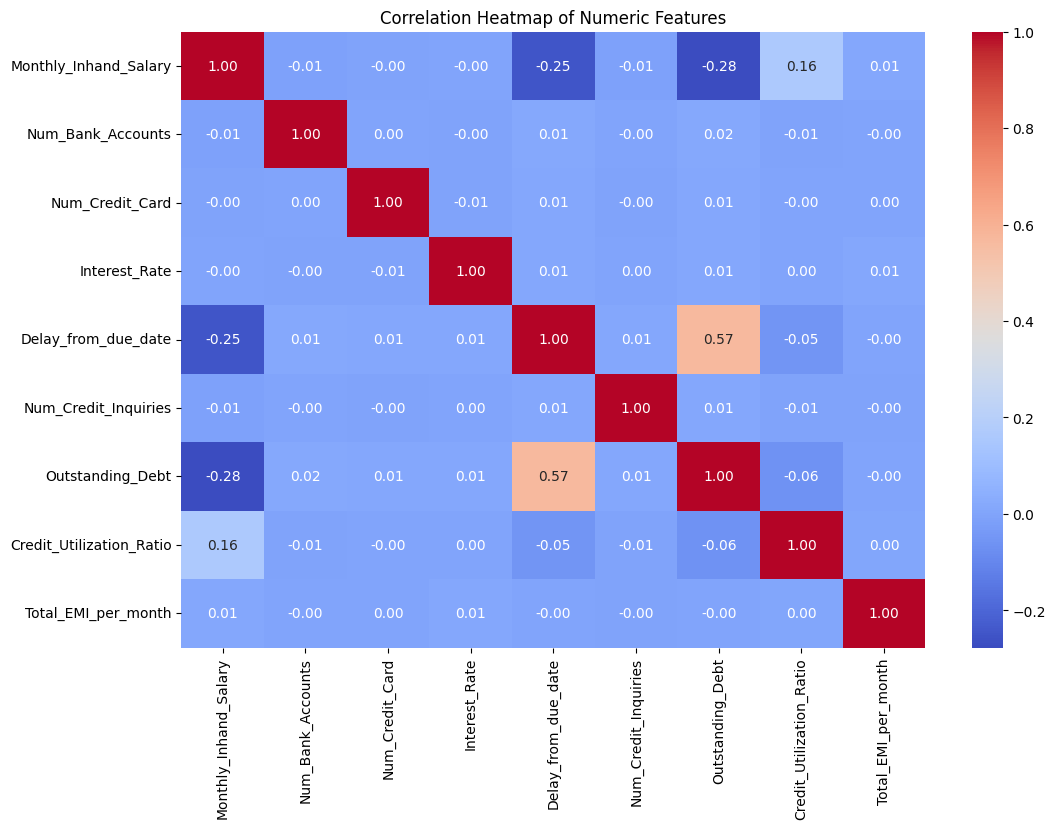

In [34]:
# Load raw data
df_raw = pd.read_csv('/kaggle/input/credit-score-classification/train.csv')

# Drop missing values
df_cleaned = df_raw.dropna()

# Convert 'Outstanding_Debt' to numeric and drop rows where it fails
df_cleaned['Outstanding_Debt'] = pd.to_numeric(df_cleaned['Outstanding_Debt'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['Outstanding_Debt'])

# Compute correlation on numeric features
numeric_features = df_cleaned.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# 🧹 Data Preprocessing : Drop missing values

In [35]:
df = df.dropna()

# Convert specified categorical columns to string type
cat_features = ['Month', 'Occupation', 'Type_of_Loan', 'Credit_Mix',
                'Payment_of_Min_Amount', 'Payment_Behaviour']
for col in cat_features:
    df[col] = df[col].astype(str)

# 🔧 Feature Engineering

In [36]:
# Grouping loan types into broad categories
df['Grouped_Loan_Type'] = df['Type_of_Loan'].apply(
    lambda x: 'Personal' if 'Personal' in x else ('Auto' if 'Auto' in x else 'Other'))

# Convert and bin 'Outstanding_Debt'
df['Outstanding_Debt'] = pd.to_numeric(df['Outstanding_Debt'], errors='coerce')
df = df.dropna(subset=['Outstanding_Debt'])
df['Debt_Level'] = pd.cut(df['Outstanding_Debt'], bins=5, labels=False)

# Label encode target column
label_map = {'Poor': 0, 'Standard': 1, 'Good': 2}
df['Credit_Score'] = df['Credit_Score'].map(label_map)

# 🧾 Prepare Features (X) and Target (y)

In [37]:
X = df.drop(columns=['Credit_Score', 'ID', 'Type_of_Loan'])  # Remove unwanted columns
y = df['Credit_Score']

# Label Encoding for categorical features
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# ⚖️ Handling Class Imbalance with SMOTE

In [38]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Splitting data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# 🧠 Model Training with CatBoost and GridSearchCV

In [7]:
model = CatBoostClassifier(verbose=0, random_state=42)

# Define hyperparameter grid
param_grid = {
    'depth': [6, 8],
    'learning_rate': [0.03, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

# GridSearchCV for tuning
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model after tuning
best_model = grid.best_estimator_
print("✅ Best Parameters Found:", grid.best_params_)

✅ Best Parameters Found: {'depth': 8, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


# 📈 Model Evaluation

In [8]:
preds = best_model.predict(X_val)
acc = accuracy_score(y_val, preds)

print(f"\n📊 Accuracy on Validation Set: {acc:.4f}")
print("\n🔍 Classification Report:")
print(classification_report(y_val, preds, target_names=['Poor', 'Standard', 'Good']))


📊 Accuracy on Validation Set: 0.8385

🔍 Classification Report:
              precision    recall  f1-score   support

        Poor       0.85      0.84      0.84      5646
    Standard       0.80      0.76      0.78      5485
        Good       0.86      0.91      0.89      5467

    accuracy                           0.84     16598
   macro avg       0.84      0.84      0.84     16598
weighted avg       0.84      0.84      0.84     16598



# 💡 Feature Importance

In [39]:
feature_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\n🔥 Top 10 Important Features:")
print(feature_imp.head(10))


🔥 Top 10 Important Features:
                 feature  importance
17      Outstanding_Debt    7.527463
15  Num_Credit_Inquiries    7.124139
11           Num_of_Loan    5.998753
0            Customer_ID    5.061151
2                   Name    5.011402
10         Interest_Rate    4.937264
19    Credit_History_Age    4.922310
12   Delay_from_due_date    4.869769
4                    SSN    4.146607
14  Changed_Credit_Limit    4.117584
